## Notebook Configuration && Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

from storesales.baseline.sales_predictor import SalesPredictor
from storesales.baseline.explore_utils import (
    family_store_con,
    store_family_prediction_plot,
)
from storesales.baseline.utils import (
    run_study,
    load_baseline_data,
    make_time_series_dataset,
    evaluate,
    make_parallel_predict,
)
from storesales.baseline.model_wrappers import (
    DailyMeanModelWrapper,
    WeightedDayMeanModelWrapper,
)
from storesales.baseline.param_suggestions import (
    IntSuggestions,
    FloatSuggestions,
)
from storesales.baseline.constants import STORES
from storesales.constants import START_TEST_DATE, HORIZON_STR

## Load Data && Create Dataset

In [3]:
train_df, test_df, holidays_df = load_baseline_data(use_light_gbm_preprocessing=False)

In [4]:
train_test_split_date = pd.Timestamp(START_TEST_DATE)

outer_cutoffs_dates = [
    "2016-08-16",
    "2016-11-18",
    "2017-02-20",
    "2017-04-04",
]
outer_cutoffs = [pd.Timestamp(date) for date in outer_cutoffs_dates]

for cutoff in outer_cutoffs:
    if cutoff + pd.Timedelta(HORIZON_STR) >= train_test_split_date:
        raise ValueError(f"cutoff {cutoff} falls into test period!")

In [5]:
# families = ["FROZEN FOODS", "EGGS"]
families = ["BREAD/BAKERY", "CELEBRATION", "LADIESWEAR"]
# families = train_df["family"].unique()

family_groups = [(family,) for family in families]

family_group_to_stores = dict(
    [[family_group, STORES] for family_group in family_groups]
)

In [6]:
families_data = train_df[train_df["family"].isin(families)]
families_test_data = test_df[test_df["family"].isin(families)]

In [7]:
train_dataset = make_time_series_dataset(families_data, outer_cutoffs, 16)

100%|██████████| 162/162 [00:00<00:00, 176.65it/s]


## SalesPredictor
### DailyMeanModel

In [8]:
daily_wrapper = DailyMeanModelWrapper(int_suggestions=[IntSuggestions("window", 3, 60)])

daily_wrapper_dict = {DailyMeanModelWrapper.__name__: daily_wrapper}

daily_optuna_kwargs = dict(
    n_trials=100,
    show_progress_bar=False,
    timeout=45,
)

daily_predictor = SalesPredictor(
    model_wrappers=daily_wrapper_dict,
    family_groups=family_groups,
    inner_cutoffs=[-365, -180, -49, -17],
    optuna_optimize_kwargs=daily_optuna_kwargs,
    n_group_store_family_choices=4,
    n_single_store_family_choices=3,
    family_group_to_stores=family_group_to_stores,
    initial=None,
)

In [9]:
daily_predictor = run_study(train_dataset, daily_predictor, disable_tqdm=False)

Family Group: ('BREAD/BAKERY',):


100%|██████████| 3/3 [00:14<00:00,  4.79s/it]


RMSLE: 0.30006273373640446
Family Group: ('CELEBRATION',):


100%|██████████| 3/3 [00:13<00:00,  4.47s/it]


RMSLE: 0.5891826296991075
Family Group: ('LADIESWEAR',):


100%|██████████| 3/3 [00:12<00:00,  4.32s/it]

RMSLE: 0.45603794515761464


In [ ]:
series_test_range = pd.date_range(
    START_TEST_DATE, train_df["ds"].max() - pd.Timedelta(days=16), freq="D"
)

predictions = make_parallel_predict(
    df=families_data,
    predictor=daily_predictor,
    series_range=series_test_range,
    disable_tqdm=False,
)

In [49]:
series_test_range.shape

(82,)

In [45]:
prediction = pd.concat(predictions)

In [50]:
prediction.info()

<class 'pandas.core.frame.DataFrame'>
Index: 212544 entries, 0 to 2591
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   family              212544 non-null  object        
 1   store_nbr           212544 non-null  int64         
 2   ds                  212544 non-null  datetime64[ns]
 3   yhat                212544 non-null  float64       
 4   y                   212544 non-null  float64       
 5   prediction_date_id  212544 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(1), object(1)
memory usage: 11.4+ MB


In [51]:
prediction[prediction["family"] == "BREAD/BAKERY"].head()

,family,store_nbr,ds,yhat,y,prediction_date_id
0,BREAD/BAKERY,1,2017-05-10,360.14015,400.233,2017-05-10
1,BREAD/BAKERY,1,2017-05-11,360.14015,395.214,2017-05-10
2,BREAD/BAKERY,1,2017-05-12,360.14015,361.828,2017-05-10
3,BREAD/BAKERY,1,2017-05-13,360.14015,463.982,2017-05-10
4,BREAD/BAKERY,1,2017-05-14,360.14015,170.293,2017-05-10


In [ ]:
daily_eval_loss = evaluate(families_data, daily_predictor, disable_tqdm=False)

In [13]:
daily_store_loss = daily_eval_loss.mean(axis=1).rename("daily_rmsle")

In [14]:
daily_store_loss.groupby(level="family").mean()

family
BREAD/BAKERY    0.236796
CELEBRATION     0.595359
LADIESWEAR      0.504007
Name: daily_rmsle, dtype: float64

### WeightedDayMeanModelWrapper

In [11]:
weighted_day_mean_wrapper = WeightedDayMeanModelWrapper(
    int_suggestions=[
        IntSuggestions("days_window", 1, 20),
        IntSuggestions("weeks_window", 1, 10),
        IntSuggestions("months_window", 0, 12),
        IntSuggestions("years_window", 0, 4),
    ],
    float_suggestions=[
        FloatSuggestions("day_weight", 0.88, 1.12),
        FloatSuggestions("week_weight", 0.88, 1.12),
        FloatSuggestions("month_weight", 0.88, 1.12),
        FloatSuggestions("year_weight", 0.88, 1.12),
        FloatSuggestions("bias", -100.0, 100.0),
    ],
)

weighted_day_mean_wrapper_dict = {
    WeightedDayMeanModelWrapper.__name__: weighted_day_mean_wrapper
}

weighted_day_mean_optuna_kwargs = dict(
    n_trials=70,
    show_progress_bar=True,
    timeout=45,
    n_jobs=6,
)

weighted_day_mean_predictor = SalesPredictor(
    model_wrappers=weighted_day_mean_wrapper_dict,
    family_groups=family_groups,
    inner_cutoffs=[-365, -180, -49, -17],
    optuna_optimize_kwargs=weighted_day_mean_optuna_kwargs,
    n_group_store_family_choices=4,
    n_single_store_family_choices=3,
    family_group_to_stores=family_group_to_stores,
    initial=None,
)

In [12]:
weighted_day_mean_predictor = run_study(
    train_dataset, weighted_day_mean_predictor, disable_tqdm=False
)

Family Group: ('BREAD/BAKERY',):


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:57<01:54, 57.20s/it]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [01:56<00:58, 58.30s/it]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

100%|██████████| 3/3 [02:55<00:00, 58.44s/it]


RMSLE: 0.3092206964364313
Family Group: ('CELEBRATION',):


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/3 [00:07<?, ?it/s]


KeyboardInterrupt: 

In [26]:
weighted_day_loss = evaluate(
    families_data, weighted_day_mean_predictor, disable_tqdm=False
)

100%|██████████| 82/82 [01:28<00:00,  1.08s/it]


In [27]:
weighted_day_store_loss = weighted_day_loss.mean(axis=1).rename("weighted_day_rmsle")

### Explore Losses

In [28]:
losses = pd.concat([daily_store_loss, weighted_day_store_loss], axis=1)

In [29]:
losses.groupby(level="family").mean()

,daily_rmsle,weighted_day_rmsle
family,,
BREAD/BAKERY,0.236941,0.202937
CELEBRATION,0.597406,0.598290
LADIESWEAR,0.505313,1.795308


In [30]:
losses["diff"] = losses["daily_rmsle"] - losses["weighted_day_rmsle"]

In [31]:
losses

daily_rmsle  weighted_day_rmsle      diff
family       store_nbr                                           
BREAD/BAKERY 1             0.335415            0.321430  0.013985
             2             0.183413            0.141802  0.041611
             3             0.167587            0.146739  0.020848
             4             0.221791            0.188429  0.033363
             5             0.164155            0.137313  0.026842
...                             ...                 ...       ...
LADIESWEAR   50            0.692497            3.013240 -2.320743
             51            0.881718            1.512953 -0.631235
             52            0.713715            2.257975 -1.544259
             53            0.797541            1.746772 -0.949232
             54            0.000000            0.000000  0.000000

[162 rows x 3 columns]

In [43]:
family_to_plot = "BREAD/BAKERY"
store_nbr_to_plot = 52

data_to_plot_df = family_store_con(train_df, family_to_plot, store_nbr_to_plot)
test_data_to_plot_df = family_store_con(test_df, family_to_plot, store_nbr_to_plot)

100%|██████████| 1/1 [00:00<00:00, 294.50it/s]


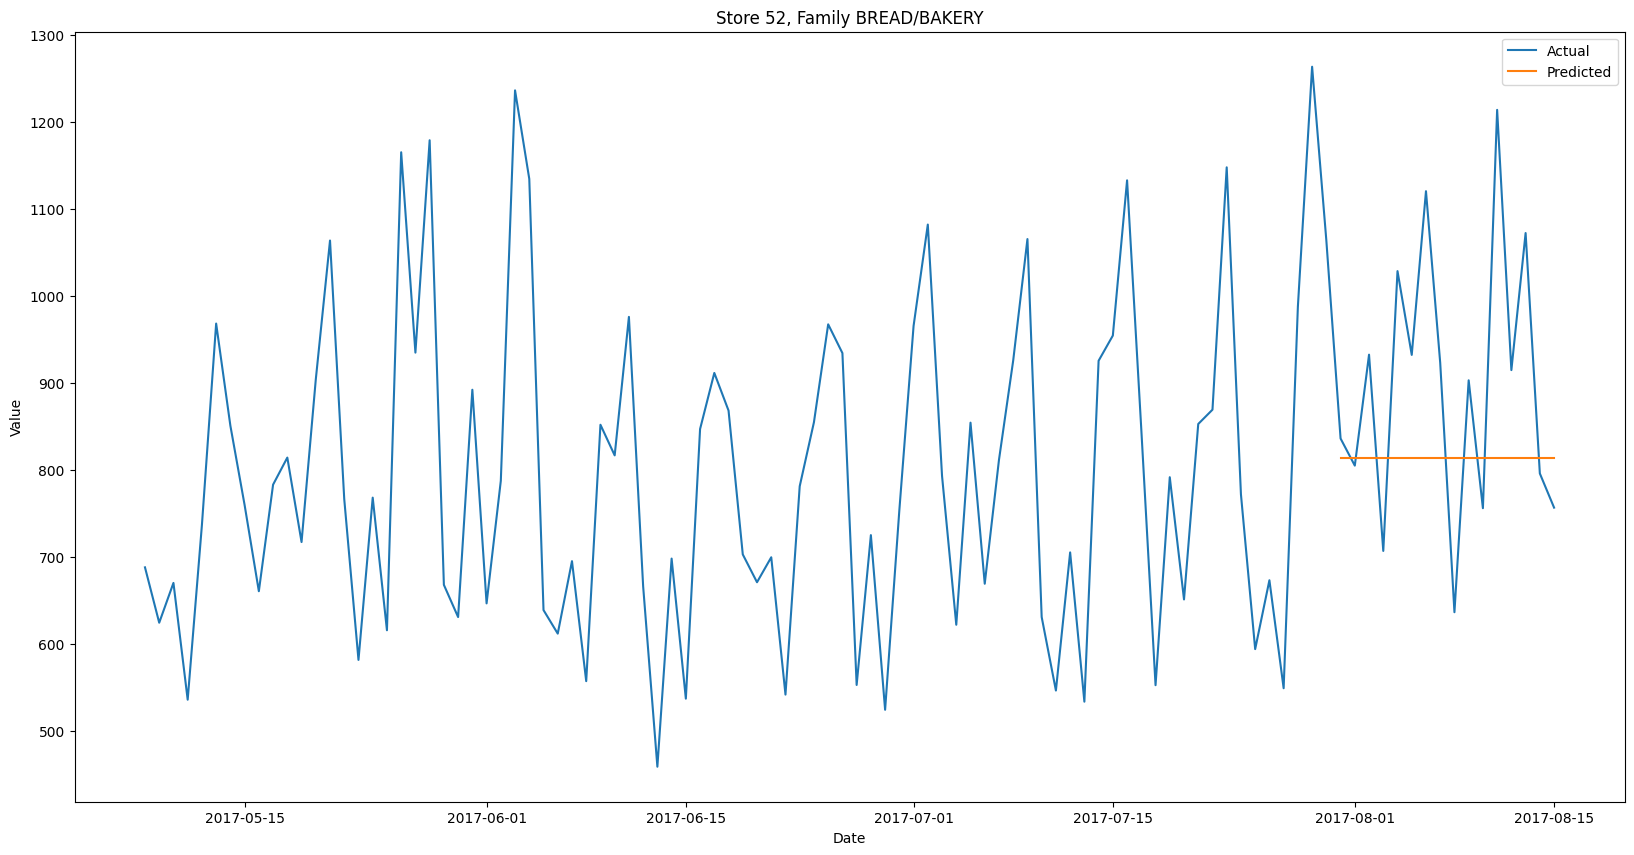

In [49]:
store_family_prediction_plot(
    predictor=daily_predictor,
    data_to_plot=data_to_plot_df,
    family=family_to_plot,
    store_nbr=store_nbr_to_plot,
    # test_data=test_data_to_plot_df,
    data_slice=100,
)

### Explore WeightedDayMeanModel Params

In [25]:
weighted_day_mean_predictor.family_to_model_params_storage

{'BREAD/BAKERY': {'params': {'model': 'WeightedDayMeanModelWrapper',
   'days_window': 10,
   'weeks_window': 6,
   'months_window': 6,
   'years_window': 1,
   'day_weight': 0.955834290460997,
   'week_weight': 1.0423341908370698,
   'month_weight': 0.9754934467250637,
   'year_weight': 0.9948456034644321,
   'bias': 0.17411954725952597},
  'stores': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
         35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
         52, 53, 54]),
  'loss': 0.30590575099267225},
 'CELEBRATION': {'params': {'model': 'WeightedDayMeanModelWrapper',
   'days_window': 8,
   'weeks_window': 6,
   'months_window': 8,
   'years_window': 2,
   'day_weight': 0.9989993515243786,
   'week_weight': 0.979259252160261,
   'month_weight': 1.0276945300906453,
   'year_weight': 0.9944297685115263,
   'bias': 0.726370420867568},
  'stores': array([ 1,  

### Save Model

In [ ]:
predictor_to_save = daily_predictor
loss_df_to_save = daily_eval_loss

predictor_to_save.fit(families_data)